In [ ]:
import re
import os
os.chdir(os.path.abspath(".."))  # now CWD is ai_scientist_project/
print(os.getcwd())

#  import packages
import numpy as np
import matplotlib.pyplot as plt
# gemini client
from dotenv import load_dotenv
from google import genai
from google.genai import types

/home/reilly/ai_scientist_project


# Extract Equations from Log File

In [6]:
# create gemini client
load_dotenv()
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))
config = types.GenerateContentConfig(temperature=1.0, max_output_tokens=5_000)

In [3]:
def get_neuron_model_docstring(log_file_path: str, iteration: int, island: int, batch: int) -> str | None:
    """
    Finds a specific neuron model in a log file and returns its docstring.

    Args:
        log_file_path: The full path to the .log file.
        iteration: The iteration number (i).
        island: The island number (j).
        batch: The batch index (k).

    Returns:
        The docstring of the specified neuron model as a string,
        or None if the ID or docstring cannot be found.
    """
    if not os.path.exists(log_file_path):
        print(f"Error: Log file not found at '{log_file_path}'")
        return None

    try:
        with open(log_file_path, 'r') as f:
            log_content = f.read()
    except Exception as e:
        print(f"Error reading log file: {e}")
        return None

    # Construct the ID string to search for
    target_id_str = f"id={iteration},{island},{batch}"
    
    # Regex to find the content block for the specific ID.
    # It captures everything from the target ID until the next 'id=' or the end of the file.
    entry_match = re.search(rf'{re.escape(target_id_str)}(.*?)(?=id=|\Z)', log_content, re.DOTALL)

    if not entry_match:
        return None

    entry_content = entry_match.group(1)

    # Regex to find the "Neuron Model:" section (non-JAX version)
    # It captures the code block following "Neuron Model:" until it hits the next major section.
    neuron_model_match = re.search(
        r'Neuron Model:\s*\n(.*?)(?=\nNeuron Model \(JAX\):|\nParameter Estimator:|\Z)',
        entry_content,
        re.DOTALL
    )

    if not neuron_model_match:
        return None

    neuron_model_code = neuron_model_match.group(1)

    # Regex to extract the content of the docstring within the code block
    docstring_match = re.search(r'"""(.*?)"""', neuron_model_code, re.DOTALL)

    if docstring_match:
        # Return the captured docstring, stripping leading/trailing whitespace
        return docstring_match.group(1).strip()

    return None

In [67]:
def get_neuron_model_equation(docstring: str) -> str | None:
    """
    Extracts the equation from the neuron model docstring.

    Args:
        docstring: The docstring of the neuron model.

    Returns:
        The equation as a string, or None if not found.
    """
    prompt = r"""
**Task:** Extract the mathematical equation from the following docstring.

**Instructions:**
1.  Format the equation in Markdown.
2.  Use fractions for any decimal numbers, eg. `0.5` should be written as `\frac{1}{2}`.
3.  The equation must begin with $R(\theta) = ... .
4.  Your response must contain **only** the Markdown equation and no other text, comments, or explanations.
5.  Use mathematical symbols and notation as appropriate. Do not use * for multiplication.
6.  Do not use words for variables, use single-letter symbols (e.g., `R`, `\theta`, `w`, `\sigma`, `A_1`, etc.). Make sensible choices for these symbols based on the context of the equation.
7.  Represent any circular distance as `d(\theta_1, \theta_2)`.
8.  If the equation uses modular arithmetic, just ignore it and write the equation as if it were not modular.
9.  Use \left( and \right) to ensure proper sizing of parentheses in the equation.

**Docstring:**"""
    prompt += docstring.strip() + "\n\n**Equation:**\n"

    # Generate content using the Gemini model
    resp = client.models.generate_content(model='gemini-2.0-flash', contents=[prompt], config=config)
    equation = resp.text.strip() if resp.text else None
    return equation

# Build Family Trees

In [ ]:
def extract_program_data_new(census, reference_loss=22.02000046):
    """
    Extracts program data from the NEW census arrays. These are not stored in such a stupid way as the old ones.
    Each program is a row in a long numpy array with the following columns:
    - 0: iteration number
    - 1: island number
    - 2: batch number
    - 3: LLM name
    - 4: loss
    - 5: time in seconds
    - 6: parent1 id (int)
    - 7: parent2 id (int)
    - 8: y_eval (float)
     
    Returns a dictionary with the following keys
    - 'scores': np.ndarray of scores (exp(-(loss - reference_loss)))
    - 'losses': np.ndarray of losses
    - 'running_max_scores': np.ndarray of running max scores
    - 'times': np.ndarray of times in seconds
    - 'parent1_id': np.ndarray of parent1 ids (int)
    - 'parent2_id': np.ndarray of parent2 ids (int)
    - 'program_id': list of tuples representing the program ids in format (iteration, island
    , batch)
    - 'llm_name': np.ndarray of LLM names (str)
    - 'innovation_indices': list of indices where innovations occurred (where the max score increases)
    - 'generations': list of lists, where generations[k] is a list of the kth order ancestors of the winner.
                     So generations[0] = [winner_index], generations[1] = [parent1_index, parent2_index], etc.
    - 'y_eval': np.ndarray of y_eval values (float)
    """
    # extract data from the census
    n_programs = census.shape[0]  # number of programs
    losses = census[:, 4]  # losses
    times = census[:, 5]  # times in seconds
    program_tuple_id = [tuple(census[i, :3]) for i in range(n_programs)]  # program ids as tuples (iteration, island, batch)
    parent1_tuple_id = census[:, 6]  # parent1 ids
    parent2_tuple_id = census[:, 7]  # parent2 ids
    llm_name = census[:, 3]  # LLM names
    y_eval = census[:, 8]  # y_eval values
    n_free_params = census[:, 9]  # number of free parameters (not used in this function, but could be useful later)

    # now loop through all programs with index >= 2 and find their parents
    parent1_int_id = [-1, -1]  # initialize parent ids with -1
    parent2_int_id = [-1, -1]  # initialize parent ids with -1
    for i in range(2, n_programs):
        p1_tuple_id = parent1_tuple_id[i]
        p2_tuple_id = parent2_tuple_id[i]
        # print(f"Processing program {i}: {program_tuple_id[i]}, parents: {p1_tuple_id}, {p2_tuple_id}")
        # print(f"p1_tuple_id.dtype: {type(p1_tuple_id)}, p2_tuple_id.dtype: {type(p2_tuple_id)}")
        p1_int_id = program_tuple_id.index(p1_tuple_id)
        p2_int_id = program_tuple_id.index(p2_tuple_id)
        # print(f"p1_int_id: {p1_int_id}, p2_int_id: {p2_int_id}")
        parent1_int_id.append(p1_int_id)
        parent2_int_id.append(p2_int_id)
    # check everyone has 2 parents
    assert len(parent1_int_id) == n_programs, "parent1_int_id must have the same length as census"
    assert len(parent2_int_id) == n_programs, "parent2_int_id must have the same length as census"

    # convert to numpy arrays
    parent1_id = np.array(parent1_int_id, dtype=int)
    parent2_id = np.array(parent2_int_id, dtype=int)
    llm_name = np.array(llm_name, dtype=str)
    # subtract the start time from all times
    times = times - np.min(times)
    # get scores
    losses = np.array(losses, dtype=float)
    losses_relative = losses - reference_loss  # relative losses
    scores = np.exp(-losses_relative)  # convert losses to scores
    running_max_scores = np.maximum.accumulate(scores)  # running max scores
    # look for innovations (where the max score increases) and get the indices
    innovation_threshold = 0.01  # threshold for innovation detection
    innovation_indices = np.where(np.diff(running_max_scores) > innovation_threshold)[0]
    innovation_indices = innovation_indices.tolist()  # convert to list for easier manipulation
    innovation_indices = [1] + innovation_indices  # include the first index

    # build family tree of winner
    index = np.argmax(scores)
    generations = [[index]]
    # now go through the most recent generation and find the parents
    all_seed = False
    while not all_seed:
        current_generation = generations[-1]
        all_seed = all([i < 2 for i in current_generation])  # check if all are seed programs
        parent_generation = []
        for idx in current_generation:
            p1_idx, p2_idx = parent1_id[idx], parent2_id[idx]
            if p1_idx >= 0:
                parent_generation.append(p1_idx)
            if p2_idx >= 0:
                parent_generation.append(p2_idx)
        parent_generation = list(set(parent_generation))
        if len(parent_generation) == 0:
            break
        generations.append(parent_generation)

    results_dict = {
        'scores': scores,
        'losses': losses,
        'running_max_scores': running_max_scores,
        'times': times,
        'parent1_id': parent1_id,
        'parent2_id': parent2_id,
        'program_id': program_tuple_id,
        'llm_name': llm_name,
        'innovation_indices': innovation_indices,
        'generations': generations,
        'y_eval': y_eval,
        'n_free_params': n_free_params
    }
    return results_dict

In [ ]:
# 'program_databases/07-15/16-22-07 (big_only)/combined/census.npy',
# 'program_databases/07-15/17-05-19 (big_only)/combined/census.npy',
# 'program_databases/07-15/17-48-16 (big_only)/combined/census.npy',
# 'program_databases/07-15/18-31-33 (big_only)/combined/census.npy',

# 'program_databases/07-16/00-59-22 (mix)/combined/census.npy',
# 'program_databases/07-16/01-46-55 (mix)/combined/census.npy',
# 'program_databases/07-16/02-29-34 (mix)/combined/census.npy',
# 'program_databases/07-16/03-15-03 (mix)/combined/census.npy',

# 'program_databases/07-17/07-14-37 (mix + image)/combined/census.npy',
# 'program_databases/07-17/08-10-17 (mix + image)/combined/census.npy',
# 'program_databases/07-17/09-07-26 (mix + image)/combined/census.npy',
# 'program_databases/07-17/10-05-55 (mix + image)/combined/census.npy',

# 'program_databases/07-20/01-37-40 (image feedback)/combined/census.npy',
# 'program_databases/07-20/02-43-00 (image feedback)/combined/census.npy',
# 'program_databases/07-20/03-45-10 (image feedback)/combined/census.npy',
# 'program_databases/07-20/04-47-23 (image feedback)/combined/census.npy',

# 'program_databases/07-16/12-46-54 (big + no_image)/combined/census.npy',
# 'program_databases/07-16/13-18-43 (big + no_image)/combined/census.npy',
# 'program_databases/07-16/13-51-51 (big + no_image)/combined/census.npy',
# 'program_databases/07-16/14-23-46 (big + no_image)/combined/census.npy',

# 'program_databases/07-16/10-46-45 (mix + no_image)/combined/census.npy',
# 'program_databases/07-16/11-18-03 (mix + no_image)/combined/census.npy',
# 'program_databases/07-16/11-48-51 (mix + no_image)/combined/census.npy',
# 'program_databases/07-16/12-18-10 (mix + no_image)/combined/census.npy',

# 'program_databases/07-17/11-02-49 (mix + no_image)/combined/census.npy',
# 'program_databases/07-17/11-42-11 (mix + no_image)/combined/census.npy',
# 'program_databases/07-17/12-22-36 (mix + no_image)/combined/census.npy',
# 'program_databases/07-17/14-55-12 (mix + no_image)/combined/census.npy',

# 'program_databases/07-17/04-58-28 (no_param_est)/combined/census.npy',
# 'program_databases/07-17/05-31-58 (no_param_est)/combined/census.npy',
# 'program_databases/07-17/06-05-20 (no_param_est)/combined/census.npy',
# 'program_databases/07-17/06-40-16 (no_param_est)/combined/census.npy',

# 'program_databases/07-17/19-02-25 (no_gradient)/combined/census.npy',
# 'program_databases/07-17/20-10-14 (no_gradient)/combined/census.npy',
# 'program_databases/07-17/21-11-44 (no_gradient)/combined/census.npy',
# 'program_databases/07-17/22-13-56 (no_gradient)/combined/census.npy',

# 'program_databases/07-20/05-52-26 (no image)/combined/census.npy',
# 'program_databases/07-20/06-26-59 (no image)/combined/census.npy',
# 'program_databases/07-20/07-01-03 (no image)/combined/census.npy',
# 'program_databases/07-20/07-35-59 (no image)/combined/census.npy',

# 'program_databases/07-21/15-31-23 (no_image)/combined/census.npy',
# 'program_databases/07-21/18-30-33 (no_image)/combined/census.npy',
# 'program_databases/07-21/19-33-36 (no_image)/combined/census.npy',
# 'program_databases/07-21/20-34-39 (no_image)/combined/census.npy',

# 'program_databases/07-22/02-35-30 (no image)/combined/census.npy',
# 'program_databases/07-22/03-16-56 (no image)/combined/census.npy',
# 'program_databases/07-22/04-01-16 (no image)/combined/census.npy',
# 'program_databases/07-22/04-47-09 (no image)/combined/census.npy',

# 'program_databases/07-22/05-31-26 (image)/combined/census.npy',
# 'program_databases/07-22/06-16-02 (image)/combined/census.npy',
# 'program_databases/07-22/07-00-37 (image)/combined/census.npy',
# 'program_databases/07-22/07-45-07 (image)/combined/census.npy',
# 'program_databases/07-23/01-00-00 (image)/combined/census.npy',

# 'program_databases/07-23/03-10-12 (text)/combined/census.npy',
# 'program_databases/07-23/04-09-16 (text)/combined/census.npy',
# 'program_databases/07-23/05-08-08 (text)/combined/census.npy',
# 'program_databases/07-23/06-07-12 (text)/combined/census.npy',

# 'program_databases/07-22/23-18-55 (image)/combined/census.npy',
# 'program_databases/07-23/00-21-26 (image)/combined/census.npy',
# 'program_databases/07-23/01-16-39 (image)/combined/census.npy',
# 'program_databases/07-23/02-14-04 (image)/combined/census.npy',

# 'program_databases/07-30/15-16-32/combined/census.npy',
# 'program_databases/07-30/16-11-02/combined/census.npy',
# 'program_databases/07-30/17-01-31/combined/census.npy',

# 'program_databases/07-30/17-52-59/combined/census.npy',
# 'program_databases/07-30/18-44-20/combined/census.npy',
# 'program_databases/07-30/19-31-37/combined/census.npy',

# 'program_databases/07-31/03-14-29/combined/census.npy',
# 'program_databases/07-31/03-52-27/combined/census.npy',
# 'program_databases/07-31/04-31-51/combined/census.npy',
# 'program_databases/07-31/05-08-24/combined/census.npy',

# 'program_databases/07-31/05-49-09/combined/census.npy',
# 'program_databases/07-31/06-20-58/combined/census.npy',
# 'program_databases/07-31/06-55-12/combined/census.npy',
# 'program_databases/07-31/07-37-03/combined/census.npy',

census_path = 'program_databases/07-22/23-18-55 (image)/combined/census.npy'
census = np.load(census_path, allow_pickle=True)
print(f"Processing {census_path}...")
results = extract_program_data_new(census)

# Plot Family Trees

In [ ]:
# Messy family tree plotter superimposed on a learning curve.


def plot_single_learning_curve(program_data_dict,
                               colour_dictionary = {'gemini-2.0-flash': '#00d335',
                                                    'gemini-2.5-flash-preview-05-20': "#2da7ff",
                                                    'seed_model': '#ffae00'}, 
                               marker_dictionary = {'gemini-2.0-flash': 'o',
                                                    'gemini-2.5-flash-preview-05-20': "p",
                                                    'seed_model': '>'},
                               plot_mode='family_tree', y_lim=None):
    """
    This function plots a learning curve for results from a single run of Edgar.
    
    Parameters:
        program_data_dict (dict): Dictionary containing the following:
            times (n_programs,): Array of times for each program.
            scores (n_programs,): Array of scores for each program.
            running_max_scores (n_programs,): Array of running max scores for each program.
            innovation_indices (list): List of INT indices where innovations occurred.
            parent1_id (n_programs,): Array of INT parent1 ids for each program.
            parent2_id (n_programs,): Array of INT parent2 ids for each program.
            program_id (n_programs,): List of tuples representing the program ids in format (iteration, island, batch).
            llm_name (n_programs,): Array of strings representing the LLM names for each program.
            generations (list): generations[k] is a list of the kth order ancestors of the winner. 
                                So generations[0] = [winner_index], generations[1] = [parent1_index, parent2_index], etc.
        colour_dictionary (dict): Dictionary mapping LLM names to colors for plotting.
        marker_dictionary (dict): Dictionary mapping LLM names to markers for plotting.
        plot_mode (str): Either 'family_tree' or 'innovations'. Determines the type
    """
    assert plot_mode in ['family_tree', 'innovations'], "plot_mode must be either 'family_tree' or 'innovations'"
    # extract data from the dictionary
    times, scores, running_max_scores, innovation_indices, parent1_id, parent2_id, program_id, llm_name, generations = \
        program_data_dict['times'], program_data_dict['scores'], program_data_dict['running_max_scores'], \
        program_data_dict['innovation_indices'], program_data_dict['parent1_id'], program_data_dict['parent2_id'], \
        program_data_dict['program_id'], program_data_dict['llm_name'], program_data_dict['generations']
    models_used = np.unique(llm_name)

    # create figure and plot scatter points for each program
    plt.figure(figsize=(12, 8))
    plt.plot(times, running_max_scores, color='red', label='Running Max Score', linewidth=2.0, zorder=0)
    for i, model_name in enumerate(models_used):
        s = 200 if model_name == 'seed_model' else 100  # larger size for seed model
        plt.scatter(times[llm_name == model_name], scores[llm_name == model_name], alpha=0.8, s=s,
                    edgecolor='black', zorder=2, color=colour_dictionary[model_name], label=model_name, marker=marker_dictionary[model_name])
    
    # if innovation mode, plot the running max scores and innovation points
    if plot_mode == 'innovations':
        for j, idx in enumerate(innovation_indices):
            plt.scatter(times[idx], scores[idx], color="#9c00c4a7", s=100, edgecolor='black', zorder=3, alpha=1 if j > 1 else 0)
    
    elif plot_mode == 'family_tree':
        # plot 2 lines joining each program to its parents
        for i in range(2, len(program_id)):
            p1_idx, p2_idx = parent1_id[i], parent2_id[i]
            if p1_idx < 0 or p2_idx < 0:  # check if parents are defined
                continue  # skip if parents are not defined
            plt.plot([times[p1_idx], times[i]], [scores[p1_idx], scores[i]], color='k',
                    linestyle='--', linewidth=0.5, alpha=0.25, zorder=0)
            plt.plot([times[p2_idx], times[i]], [scores[p2_idx], scores[i]], color='k',
                    linestyle='--', linewidth=0.5, alpha=0.25, zorder=0)
            
        # plot the winners family tree in bold
        for i in range(len(generations) - 1):
            ancestors = generations[i]
            for a in ancestors:
                p1, p2 = parent1_id[a], parent2_id[a]
                if p1 < 0 or p2 < 0:  # check if parents are defined
                    continue  # skip if parents are not defined
                # plot line from child to parents
                plt.plot([times[p1], times[a]], [scores[p1], scores[a]], color='black',
                        linestyle='-', linewidth=2.0, alpha=0.8, zorder=0, label='Winner Family Tree' if i == 0 else "")
                plt.plot([times[p2], times[a]], [scores[p2], scores[a]], color='black',
                        linestyle='-', linewidth=2.0, alpha=0.8, zorder=0)

    # add vertical line at the beginning of each iteration
    iter_no = np.array([pid[0] for pid in program_id])  # extract iteration number from program_id
    n_iterations = np.max(iter_no)
    iter_start_times = np.zeros(n_iterations)
    plt.axvline(x=0, color='grey', linestyle='--', linewidth=2.0, zorder=0)  # first iteration starts at time 0
    for i in range(n_iterations - 1):
        iter_start_times[i] = np.max(times[iter_no == i+1]) + 10
        plt.axvline(x=iter_start_times[i], color='grey', linestyle='--', linewidth=1.5, zorder=0)

    # clean axes
    plt.grid(True, linestyle='--', alpha=0.5)
    if y_lim is not None:
        plt.ylim(y_lim)
    # add x-ticks every 5 minutes (requires converting seconds to minutes)
    xticks = np.arange(0, np.max(times), 300)
    plt.xticks(xticks, [f'{int(t/60)}' for t in xticks], fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.legend(loc='upper right', fontsize=16)
    plt.title('Likelihood Over Time', fontsize=20)
    plt.xlabel('Time (mins)', fontsize=20)
    plt.ylabel(r'$\frac{\text{Likelihood}(\text{Best Model})}{\text{Likelihood}(\text{Seed Model})}$', fontsize=20)
    plt.tight_layout()
    plt.show()

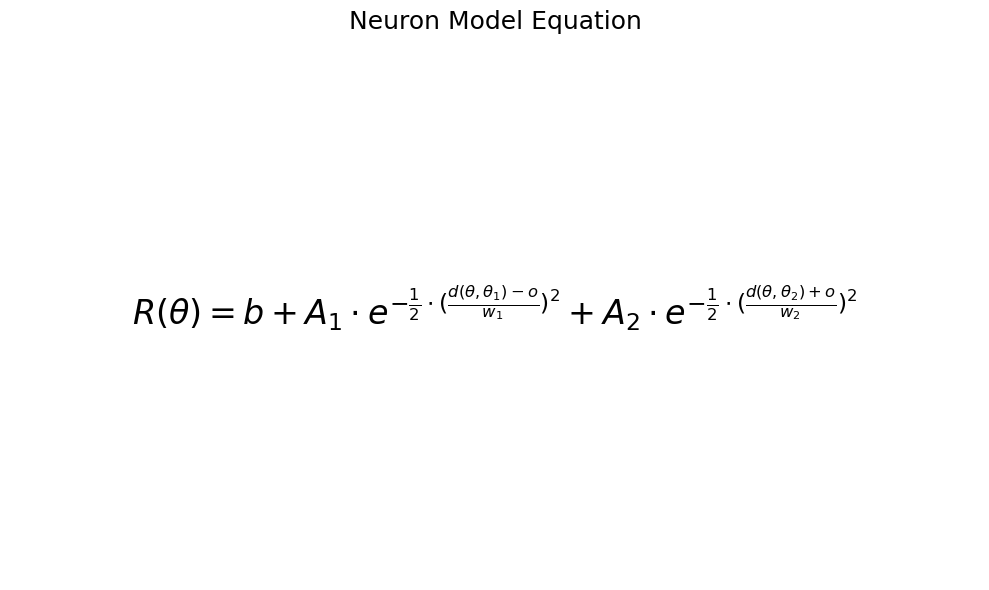

In [ ]:
# Big Family Tree Plot without learning Curve

# ────────────────────────────────────────────────────────────────
# 0.  Custom look‑ups  (add more entries if new LLMs appear)
# ────────────────────────────────────────────────────────────────
colour_dictionary = {
    'gemini-2.0-flash': '#00d335',
    'gemini-2.5-flash-preview-05-20': "#2da7ff",
    'seed_model': '#ffae00'
}
marker_dictionary = {
    'gemini-2.0-flash': 'o',
    'gemini-2.5-flash-preview-05-20': "p",
    'seed_model': '>'
}


# ────────────────────────────────────────────────────────────────
# 1.  Build the lineage tree   (unchanged logic)
# ────────────────────────────────────────────────────────────────
def build_lineage(results_list, best_idx):
    tree = {}
    last_gen = len(results_list) - 1

    def add(gen, idx):
        node = (gen, idx)
        if node in tree:
            return
        p1 = results_list[gen]['parent1_id'][idx]
        p2 = results_list[gen]['parent2_id'][idx]
        parents = [(gen - 1, p) for p in (p1, p2) if p != -1]
        tree[node] = parents
        for parent in parents:
            add(*parent)

    add(last_gen, best_idx)
    return tree, last_gen


# ────────────────────────────────────────────────────────────────
# 2.  NEW vertical‑positioning routine
# ────────────────────────────────────────────────────────────────
def assign_positions(tree, last_gen, best_idx, min_gap=1.0):
    """
    Returns {node: (x, y)} where:
      x = generation  (0 = seeds, last_gen = best program)
      y = unique, nicely spaced value:
            • each seed is at least `min_gap` apart
            • siblings have distinct y's, parent is centred over children
            • the best‑program node ends up on y = 0 (recentred)
    """
    # ---- helper: depth‑first walk from seeds upward --------------
    child_map = tree            #   child_map[parent] = [children…]
    y_raw, next_y = {}, 0       #   y assigned bottom‑up, seed by seed

    def dfs(node):
        nonlocal next_y
        children = child_map[node]
        if not children:                       # ① seed → get next free slot
            y_raw[node] = next_y
            next_y += min_gap
        else:                                  # ② internal → recurse first
            for c in children:
                dfs(c)
            # place parent exactly between its (now placed) children
            y_raw[node] = np.mean([y_raw[c] for c in children])

    root = (last_gen, best_idx)
    dfs(root)

    # ---- re‑centre so the root sits on y = 0 ---------------------
    shift = y_raw[root]
    pos = {n: (n[0], y_raw[n] - shift) for n in y_raw}
    return pos


# ────────────────────────────────────────────────────────────────
# 3.  Plot with size = f(score), colour & marker = f(llm_name)
# ────────────────────────────────────────────────────────────────
def plot_lineage(results_list,
                 best_idx,
                 llm_name,
                 program_id,
                 y_eval,
                 colour_dict=colour_dictionary,
                 marker_dict=marker_dictionary):

    tree, last_gen = build_lineage(results_list, best_idx)
    pos  = assign_positions(tree, last_gen, best_idx, min_gap=2.0)
    pos[(8, np.int64(0))] = (8, -3.0)  # manually adjust the position of the seed program
    pos[(8, np.int64(1))] = (8, 3.0)  # manually adjust the position of the seed program

    fig, ax = plt.subplots(figsize=(18, 14))
    # 3‑a  edges with arrows
    for child, parents in tree.items():
        x_c, y_c = pos[child]
        for p in parents:
            x_p, y_p = pos[p]
            ax.annotate("",
                        xy=(x_c, y_c), xytext=(x_p, y_p),
                        arrowprops=dict(arrowstyle="-|>",
                                        mutation_scale=12,
                                        lw=1.3,
                                        color="gray",
                                        shrinkA=6, shrinkB=9),
                        zorder=1)

    # 3‑b  scatter nodes and attach spark‑lines
    for mk in set(marker_dict.values()):
        nodes = [n for n in tree if marker_dict.get(llm_name[n[1]], "o") == mk]

        # scatter
        xs = [pos[n][0] for n in nodes]
        ys = [pos[n][1] for n in nodes]
        
        cs = [colour_dict.get(llm_name[n[1]], "#bbbbbb") for n in nodes]
        ax.scatter(xs, ys, s=1500, c=cs, marker=mk,
                   edgecolors="black", zorder=3)

        # spark‑lines
        for n in nodes:
            x, y = pos[n]
            curve = y_eval[n[1]]           # length‑100
            c_max = np.max(curve)

            # create inset anchored in data coords
            inset = ax.inset_axes([x - 0.2, y + 0.40, 0.4, 0.75], transform=ax.transData, zorder=2)

            inset.plot(curve, lw=2, color="black")
            inset.set_xticks([]); inset.set_yticks([]); inset.set_ylim(0, 1.4 * c_max)
            inset.spines[:].set_visible(True)
            # inset.set_facecolor("none")

    # 3‑c  black labels (program IDs)
    k = 0
    for n, (x, y) in pos.items():
        # ax.text(x, y, str(program_id[n[1]])[1:-1],
        ax.text(x, y, f"{k}",
                ha="center", va="center", fontsize=8, color="black", zorder=4)
        k += 1
    # cosmetics
    ax.set_title(f"Full Ancestry of Best Program (index {best_idx})",
                 fontsize=14)
    # ax.set_xlabel("Generation →")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# ────────────────────────────────────────────────────────────────
# 4.  Call it
# ────────────────────────────────────────────────────────────────
exp_idx = 1  # index of the experiment to plot
scores = results_list[exp_idx]['scores']
llm_name = results_list[exp_idx]['llm_name']
best_program_index = np.argmax(scores)
program_id = results_list[exp_idx]['program_id']
y_eval = results_list[exp_idx]['y_eval']
cell_no = np.random.randint(0, y_eval[0].shape[0])  # random cell number for y_eval
# cell_no = 225
# cell_no = 104
# cell_no = 128
y_eval = y_eval[:, cell_no]
# y_eval = np.roll(y_eval, 25, axis=1)  # roll the y_eval array to shift the angles
print(cell_no)
plot_lineage(results_list, best_program_index, llm_name, program_id, y_eval)